In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch

from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

In [ ]:
data_name = "DS03"
perform_name = 'T48'

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data

In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].astype(int).unique().tolist()
units

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
performs_train = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_alias
}
time_train = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [ ]:


eval_data = {}
eval_eol = {}
for unit in units:
    t_data = time_train[unit]
    s_data = performs_train[perform_name][unit]
    eval_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32).to(device)
    eval_eol[unit]=torch.tensor(t_data[-1],dtype=torch.float32) 


In [8]:
train_degmodels = {}
for eval_unit in units:
    degmodels=[]
    for unit, perform in performs_train[perform_name].items():
        if unit == eval_unit:
            continue
        best_model = NModel()
        best_model.load_state_dict(
            torch.load(states_dir /perform_name/f'unit_{unit}'/ "best_model.pt", map_location=device)
        )
        best_model.to(device)
        degmodels.append(best_model)
    train_degmodels[eval_unit] = degmodels

## Train Particle Filter Net

In [ ]:
n_epochs = 5000
n_particles = 1600
multiply_scale = 0.5
start_idx = 5 

bckp_freq = 1

In [10]:
net = ParticleFilterMLP(state_dim=5, hidden_dims=[128, 128, 32]).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


losses = []
epochs = []


n_loss = 0
best_loss = float('inf')
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for eval_unit in units:
        degmodels = train_degmodels[eval_unit]
        t_data = eval_data[eval_unit][:, 0]
        s_data = eval_data[eval_unit][:, 1]
        # ---- start of a new accumulation window ----
        if epoch % bckp_freq == 0:
            optimizer.zero_grad()
            unit_loss = 0.0
            n_loss = 0

        pf = ParticleFilterModel(
            base_models=degmodels,
            net=net,
            max_life=100.0,
            n_particles=n_particles,
            multiply_scale=multiply_scale,
            name=perform_name,
        ).train()

        for k in range(start_idx, len(t_data)):
            mixture_dist = pf.step(
                t_obs=t_data[:k],
                s_obs=s_data[:k],
            )
            last_dist = mixture_dist.distribution(s=s_data[[-1]])
            nll = -last_dist.log_prob(t_data[[-1]]).mean()
            unit_loss += nll
            n_loss += 1

        # ---- end of accumulation window ----
        if (epoch + 1) % bckp_freq == 0:
            unit_loss = unit_loss / n_loss
            unit_loss.backward()
            optimizer.step()
            epoch_loss += unit_loss

    epoch_loss/= len(units)
    print(f"[Epoch {epoch:03d}] total_loss = {epoch_loss.item():.2f}")
    losses.append(epoch_loss.item())
    epochs.append(epoch)
    
    # ---- save best model ----
    if epoch_loss.item() < best_loss:
        best_loss = epoch_loss.item()
        torch.save(
            net.state_dict(),
            states_dir / perform_name / "best_pf_net.pt",
        )
        print("  + saved ")

[Epoch 000] total_loss = 3.76
  + saved 
[Epoch 001] total_loss = 3.71
  + saved 
[Epoch 002] total_loss = 3.76
[Epoch 003] total_loss = 3.73
[Epoch 004] total_loss = 3.74
[Epoch 005] total_loss = 3.74
[Epoch 006] total_loss = 3.75
[Epoch 007] total_loss = 3.73
[Epoch 008] total_loss = 3.76
[Epoch 009] total_loss = 3.72
[Epoch 010] total_loss = 3.75
[Epoch 011] total_loss = 3.74
[Epoch 012] total_loss = 3.76
[Epoch 013] total_loss = 3.75
[Epoch 014] total_loss = 3.75
[Epoch 015] total_loss = 3.78
[Epoch 016] total_loss = 3.74
[Epoch 017] total_loss = 3.72
[Epoch 018] total_loss = 3.75
[Epoch 019] total_loss = 3.74
[Epoch 020] total_loss = 3.73
[Epoch 021] total_loss = 3.75
[Epoch 022] total_loss = 3.76
[Epoch 023] total_loss = 3.74
[Epoch 024] total_loss = 3.76
[Epoch 025] total_loss = 3.73
[Epoch 026] total_loss = 3.72
[Epoch 027] total_loss = 3.77
[Epoch 028] total_loss = 3.72
[Epoch 029] total_loss = 3.72
[Epoch 030] total_loss = 3.78
[Epoch 031] total_loss = 3.74
[Epoch 032] total_

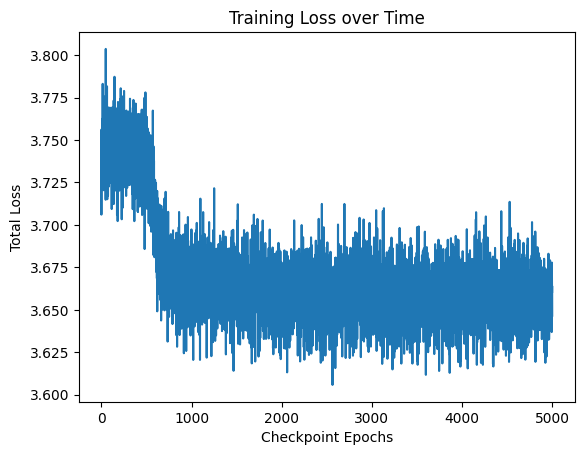

In [11]:
from matplotlib import pyplot as plt
plt.plot(epochs,losses)
plt.xlabel('Checkpoint Epochs')
plt.ylabel('Total Loss')
plt.title('Training Loss over Time')
plt.show()